# Statistical Tests Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [3]:
# set the username for the path of the files:
#user='LB'
user='AF'

if user=='LB':
    file_path='/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
elif user=='AF':
    file_path='E:/grb_to_test/CGRO_BATSE/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')


## Sample 1: BASTE Data

### Test 1: Duration (T90) distribution <br>
__T90 definition__ <br> 
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected. <br>
_(definition from: https://heasarc.gsfc.nasa.gov/grbcat/notes.html)_ <br>


NB: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano. The file is uploaded on the repository for easier access. <br>
_(file path on Gravity: `/astrodata/guidorzi/CGRO_BATSE/T90_full.dat`, file path on the repository: `lc_pulse_avalance/statistical_tests/cgro_batse/T90_full.dat`)_


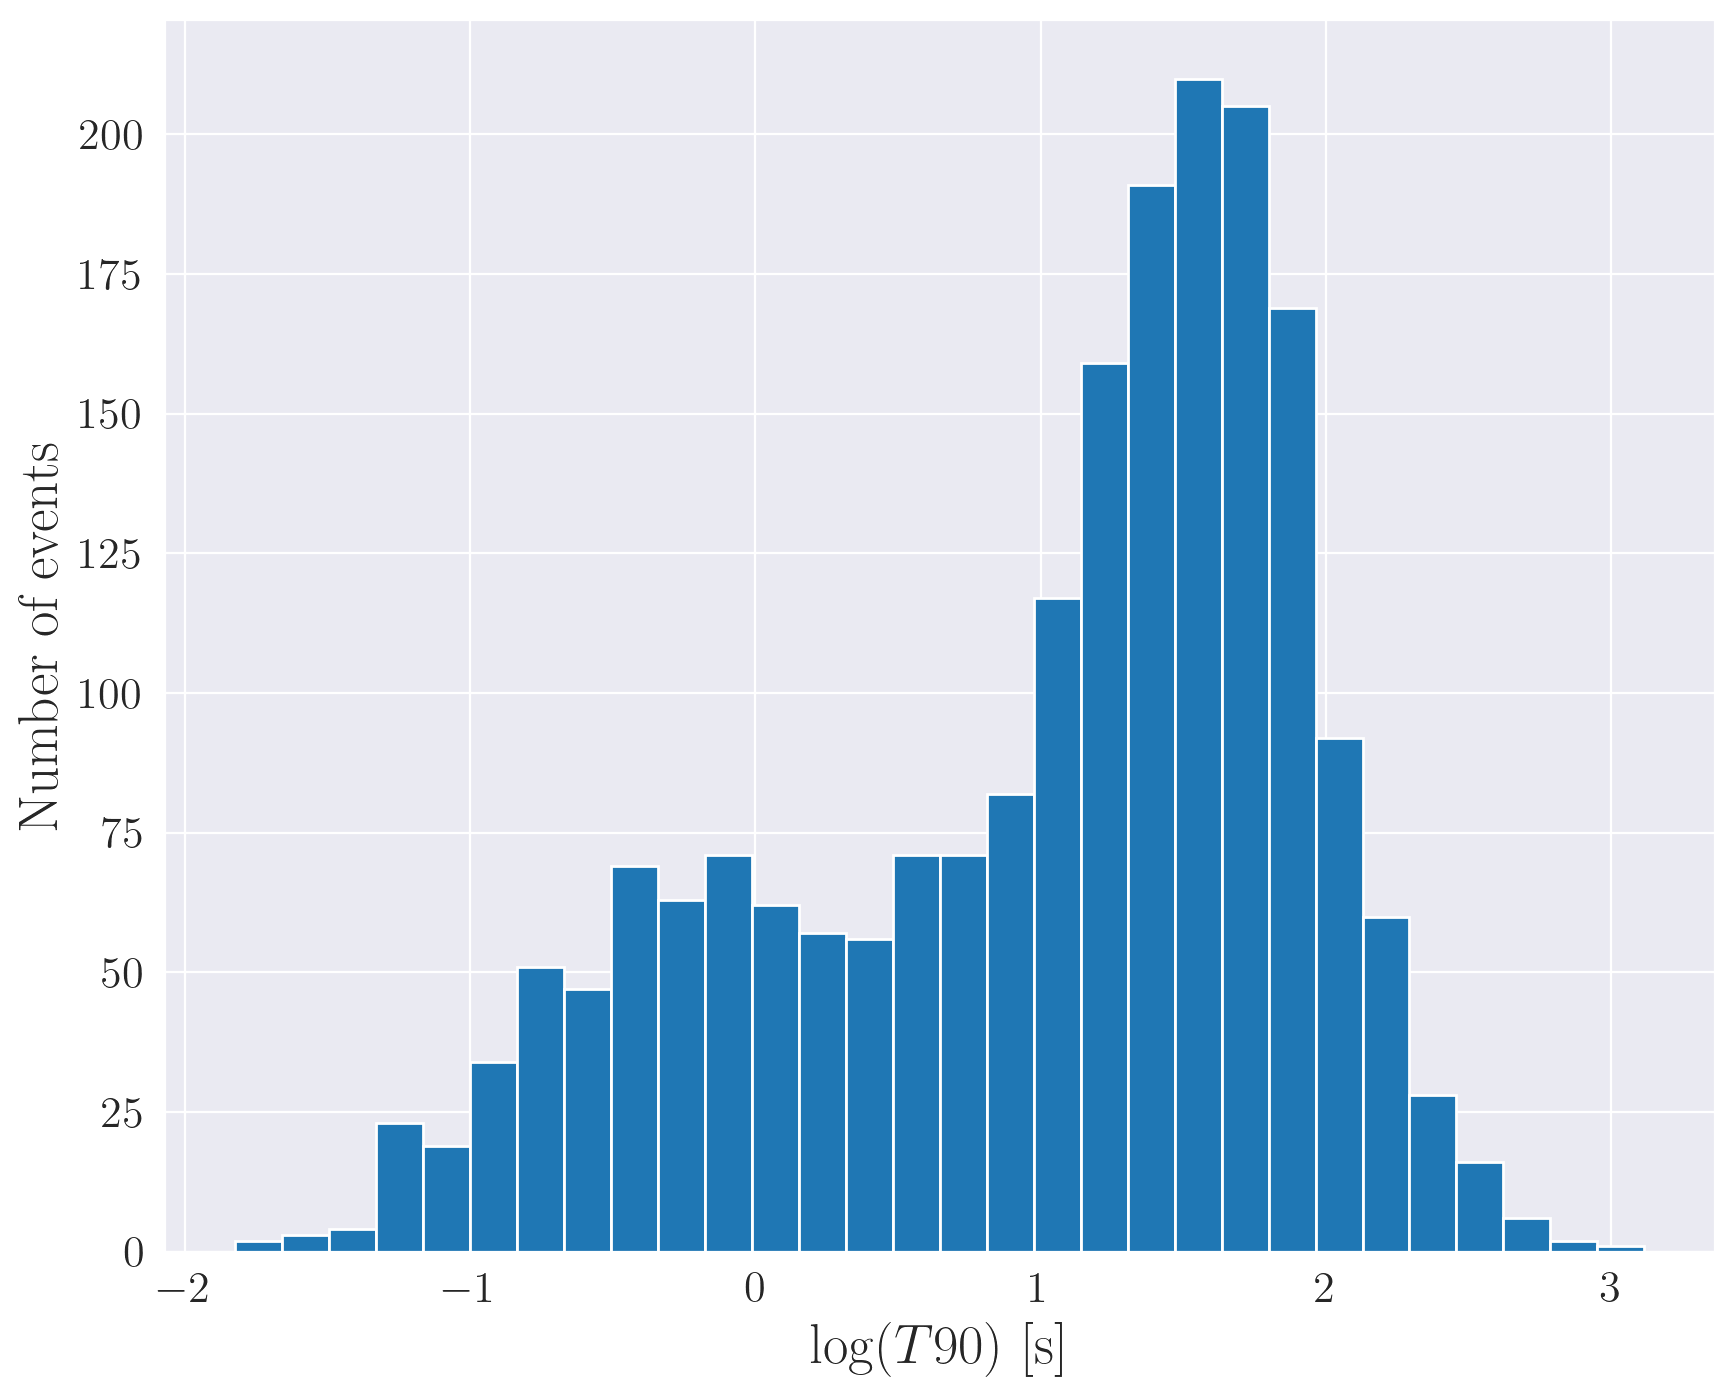

In [4]:
filename='T90_full.dat'

grb, t90, t90_error = np.loadtxt(file_path+filename, unpack=True)
log10_t90 = np.log10(t90)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.set_axisbelow(True)
#ax.grid(which = 'both')
ax.set_ylabel('Number of events', size=20)
ax.set_xlabel(r'$\log(T90)$ [s]', size=20)

n, bins, patches = ax.hist(log10_t90, 
                           bins=30)
                           #facecolor='lightgrey',
                           #edgecolor='black')

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

t90_avg = np.mean(t90)
t90_var = np.var(t90)

#### T90 Calculation function
A function to evaluate the T90 of a GRB given 
1. times of the lightcurve bins, and
2. counts per bin 

In [5]:
def evaluateT90(times, counts):
    cumulative_counts = np.round(np.cumsum(counts)/np.sum(counts)*100)
    t_5  = times[np.where(cumulative_counts ==  5)[0][0]]
    t_95 = times[np.where(cumulative_counts == 95)[0][0]]
    return t_95-t_5

## Test 2: Average Peak-Aligned Profiles

Following the technique described in Mitranof et al., 1996 (https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract) and working on the time interval from 0 to 150 s from the peak (as done in Stern+1996)

#### (WIP)

In [6]:
###########                  TEST ON A BUNCH OF GRBs                ############
########### TESTED on all the long GRBs in alltrig_long.list        ############

t_i=0          # [s]
t_f=150        # [s]
bin_time=0.064 # [s] temporal bins for BATSE

# small sample of GRBs:
#grb_list = ["00105_all_bs.out","00107_all_bs.out","00108_all_bs.out","00109_all_bs.out","00110_all_bs.out"]

# full sample of GRBs:
grb_list = [grb_num.rstrip('\n') + '_all_bs.out' for grb_num         \
            in open(file_path + 'alltrig_long.list').readlines()] +  \
            [grb_num.rstrip('\n') + '_all_bs.out' for grb_num        \
            in open(file_path + 'alltrig_short.list').readlines()]

test_times      = np.arange(t_i, t_f, bin_time) # Same time range as in Stern+1996
averaged_fluxes = np.zeros_like(test_times)

for grb in grb_list:
    times, counts, errs = np.loadtxt(file_path+grb, unpack=True)
    c_max   = np.max(counts)
    i_t_max = np.where(counts == c_max)[0][0] # LB: you can also use 'np.argmax()' here
    t_max   = times[i_t_max]
    counts_to_sum = counts[i_t_max:i_t_max + len(test_times)] / c_max
    if len(counts_to_sum) < len(test_times):
        counts_to_sum = np.concatenate([counts_to_sum, [0]*(len(test_times) - len(counts_to_sum))])
    averaged_fluxes += counts_to_sum

averaged_fluxes /= len(grb_list)
#Plot of <F/Fp> and <F/Fp>^3 in the next cell

In [9]:
len(grb_list)

1922

Note: some negative values (close to zero) appearing for $t^{1/3} > 4$. 

LB: @AF, Cristiano ha detto di ribinnare la parte finale della curva, in modo tale che quei bin contengano un segnale significativo (i.e., $>1 \sigma$, o almeno che sia positivo). 

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


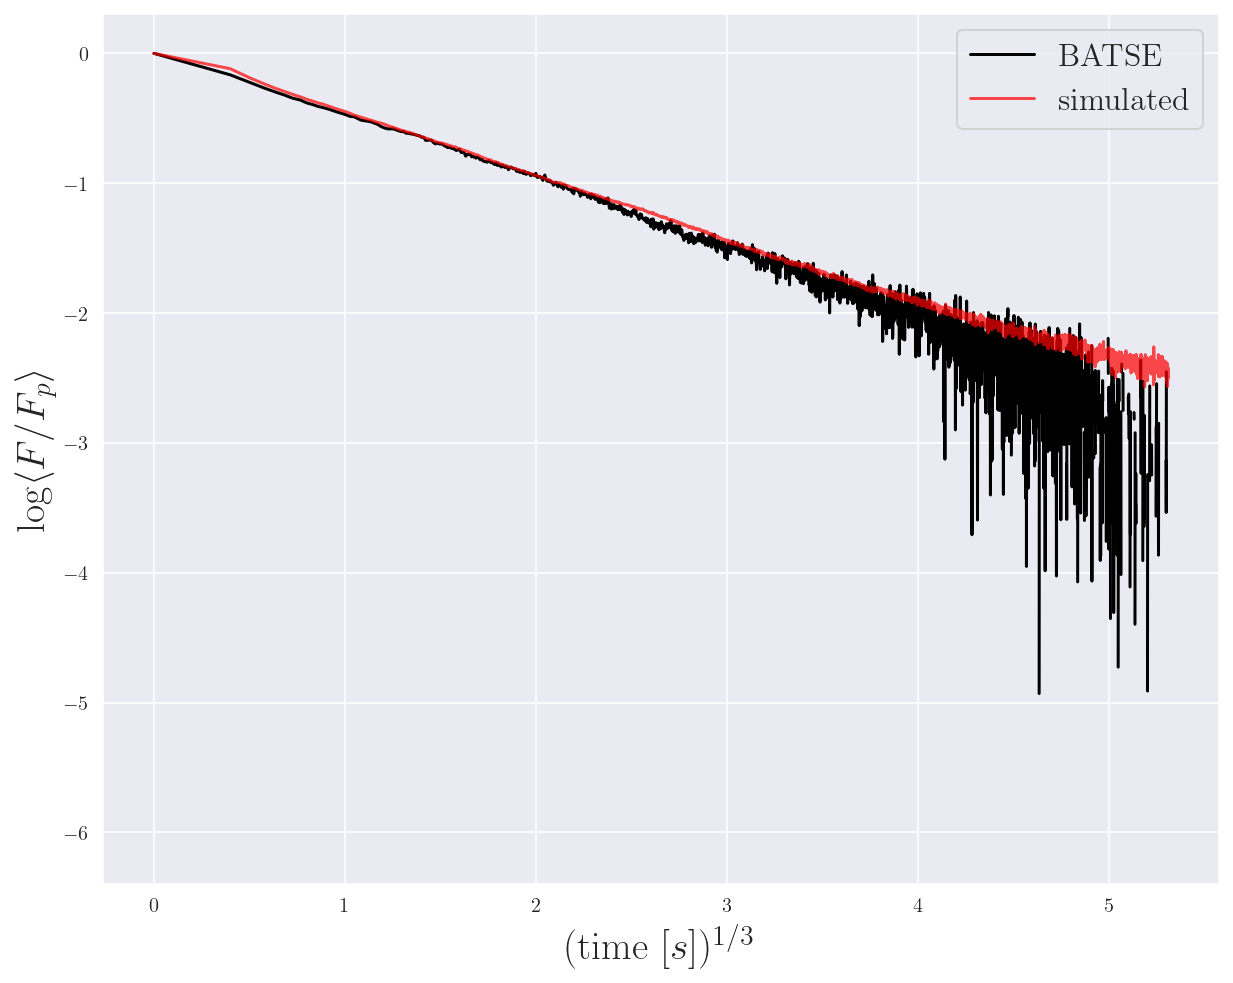

In [7]:
simulations_file = './simulations.txt'
simulated_times, simulated_fluxes = np.loadtxt(simulations_file, unpack=True)
n_step_sim       = int(t_f/bin_time)
simulated_times  = np.array(simulated_times[:n_step_sim])
simulated_fluxes = np.array(simulated_fluxes[:n_step_sim])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.set_axisbelow(True)
#ax.grid(which = 'both')
ax.set_ylabel('log <F/Fp>')
ax.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=20)
ax.set_ylabel(r'$\log \langle F/F_p\rangle$',  size=20)
ax.plot(simulated_times**(1/3), np.log10(averaged_fluxes[:-1]),  color = 'black', label = 'BATSE')
ax.plot(simulated_times**(1/3), np.log10(simulated_fluxes),      color = 'red',   label = 'simulated', alpha=0.7)
ax.legend(prop={'size':16})
plt.show()

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


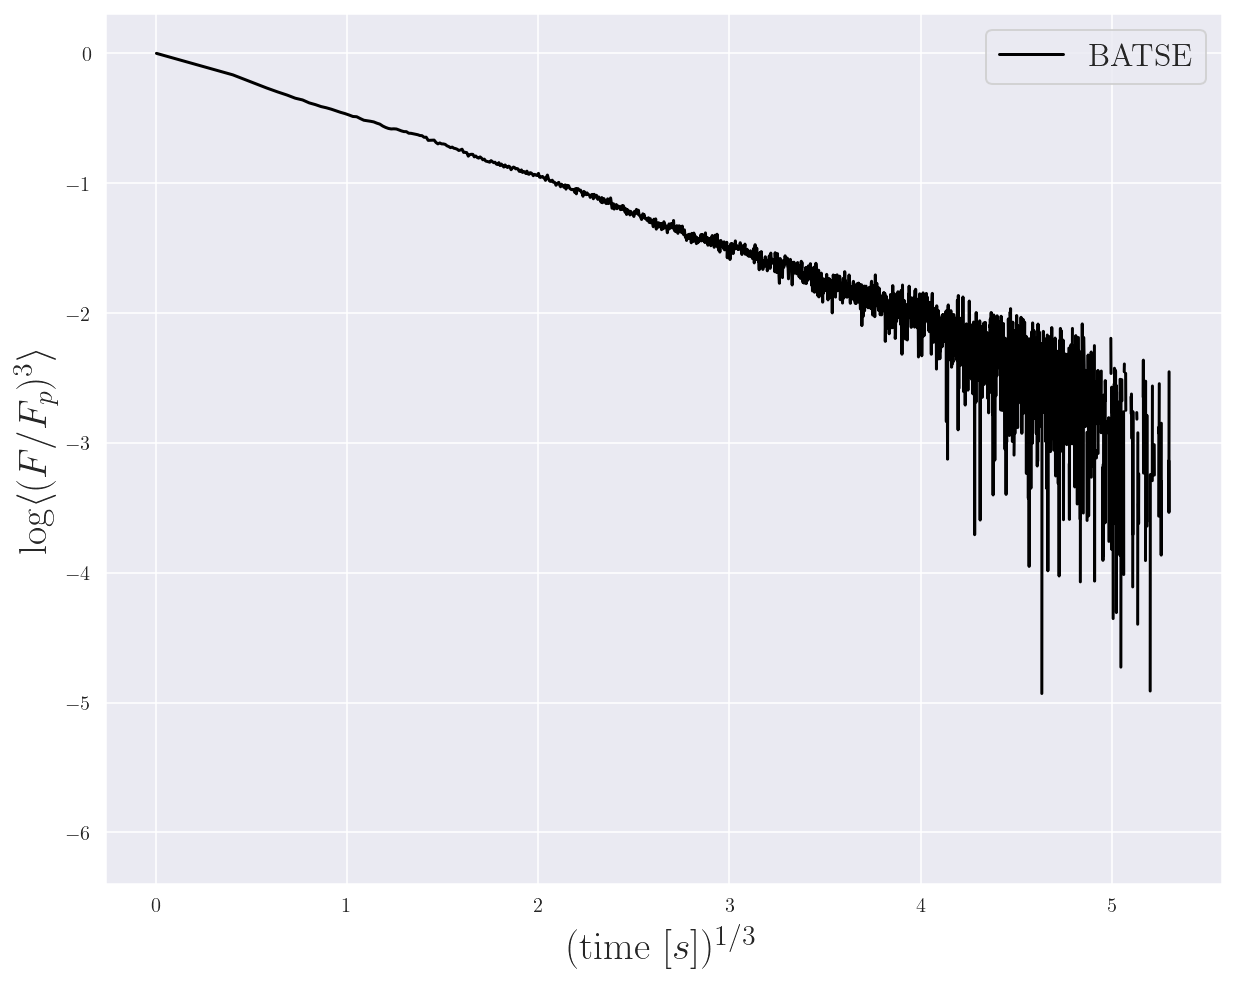

In [8]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.set_axisbelow(True)
#ax.grid(which = 'both')
ax.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=20)
ax.set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$',  size=20)
ax.plot(test_times**(1/3), np.log10(averaged_fluxes), color = 'black', label = 'BATSE')
ax.legend(prop={'size':16})
plt.show()

Note: Going at late times, the data start to be very scattered. Maybe we have to make a selection of GRBs to use for the plot?

## Test 3: Autocorrelation

Following the technique described in Link et al. 1993 (https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)

#### (WIP)
Probably not working at the moment

In [35]:
t_i=0          # [s]
t_f=150        # [s]
bin_time=1     # [s]

# small sample of GRBs:
grb_list  = ["00105_all_bs.out","00107_all_bs.out","00108_all_bs.out","00109_all_bs.out","00110_all_bs.out"]

# full sample of GRBs:
# grb_list = [grb_num.rstrip('\n') + '_all_bs.out' for grb_num         \
#             in open(file_path + 'alltrig_long.list').readlines()] +  \
#             [grb_num.rstrip('\n') + '_all_bs.out' for grb_num        \
#             in open(file_path + 'alltrig_short.list').readlines()]

steps = np.arange(int(t_f/bin_time))
acf = np.zeros_like(steps)
for grb in grb_list:
    times, counts, errs = np.loadtxt(file_path+grb_list[0], unpack=True)
    acf = acf + [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in steps]
acf /= len(grb_list)

In [ ]:
#Plot average acf
acf[acf <= 0] = 1
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
#ax.grid()
ax.plot((steps*bin_time)**(1/3),np.log10(acf), marker = '+')
plt.show()

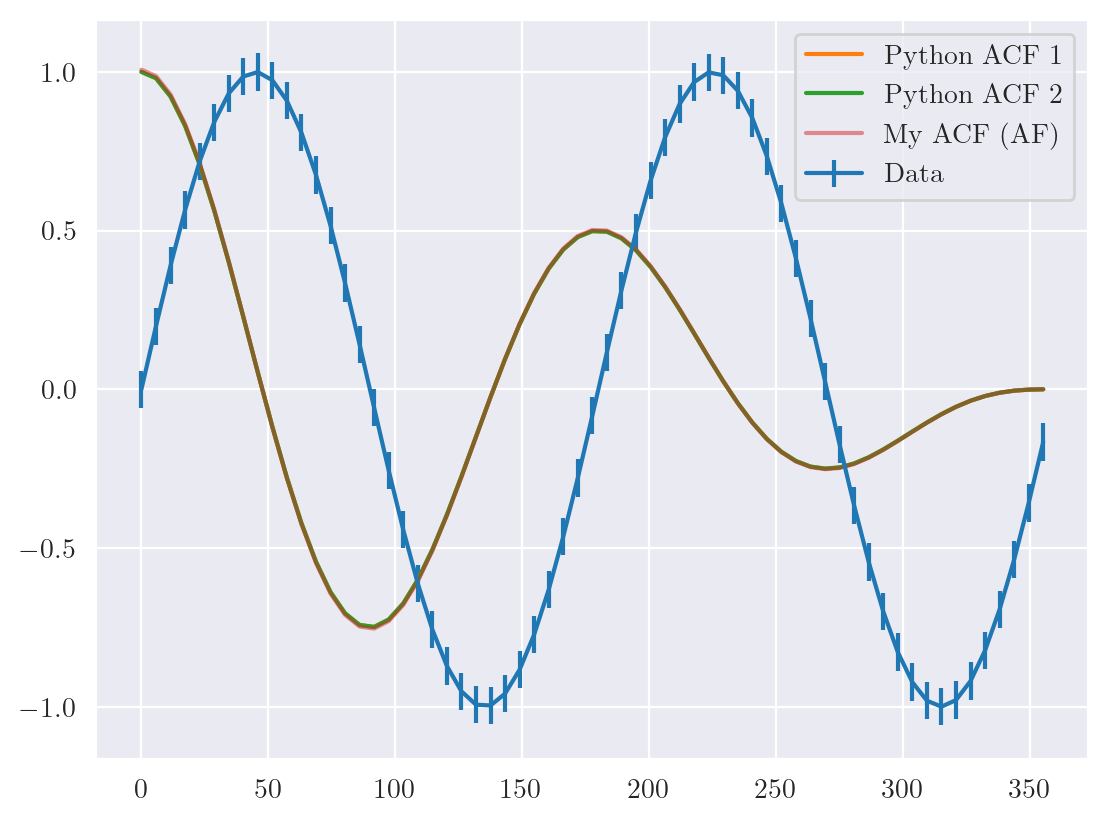

In [24]:
#AUTOCORRELATION TEST CELL
#Testo qui alcuni metodi per fare autocorrelazione con Python su dei dati più semplici da interpretare
import statsmodels.api as sm


times = np.arange(0, 2*np.pi, 0.1)
counts = np.sin(times * 2)
error = np.random.rand()*0.1
plt.errorbar(times*180/np.pi, counts, yerr = error, label = 'Data')

#With function in statsmodels
acorr = sm.tsa.acf(counts, nlags = len(times) -1)
plt.plot(times*180/np.pi, acorr, label = 'Python ACF 1')

#With numpy correlate. Code taken from:
#https://scicoding.com/4-ways-of-calculating-autocorrelation-in-python/#:~:text=Autocorrelation%20is%20a%20function%20that,algorithm%20in%20Python%20using%20autocorrelation.
data = counts
# Mean
mean = np.mean(data)
# Variance
var = np.var(data)
# Normalized data
ndata = data - mean
acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
acorr = acorr / var / len(ndata)
plt.plot(times*180/np.pi, acorr, label = 'Python ACF 2')

#The code I used above
acf = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - error**2) for u in range(len(times))]
plt.plot(times*180/np.pi, acf, label = 'My ACF (AF)', alpha = 0.5)
plt.legend()
#In the end, it seems like the three codes are equivalent


